#### Import Data and Library 

In this section I create 3 datasets: 
1. Complete Dataset with all data
2. Data of individuals who have a high Climate Change Risk Perception (q2 >= 6) 
2. Data of individuals who have Low Climate Change Risk Perception (q2 <= 5) 

With all datasets I will predict pro-environmental behaviour (qb5). 

In [30]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image 
from pydot import graph_from_dot_data
import pandas as pd
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve, f1_score
from sklearn.metrics import classification_report
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import RandomizedSearchCV

df = pd.read_csv('df-climatechange.csv')
df = df.drop(['qb1a'], axis = 1)
df['qb5'] = df['qb5'].replace({'No': 0, 'Yes':1})

#pd.set_option('display.max_columns', None)
df1 = df[df.qb2 >= 6]
df2 = df[df.qb2 <= 5]

#### Set parameters for Random Search

In [31]:
param_dict = {
    "criterion": ['gini', 'entropy'], 
    "max_depth": range(1,10), 
    "min_samples_split": range(0 , 10), 
    "min_samples_leaf": range(1,5)
}


### Complete Dataset

In this part there is the complete dataset. I will predict pro-environmental behaviour (qb5). The predictors are: climate change risk perception, clusters and correlational class analysis of other questions about climate change, socio-demograpich variables. 

In [32]:
cc_num = df[['qb5', 'qb2' , 'd1', 'd10','d11', 'country','d8','d25', 'd63','d7','cluster', 'cca']]

cat_var =['d1','d10', 'country','d8','d25', 'd63','d7','cluster', 'cca']
df_get_dummies = pd.get_dummies(  cc_num , columns = cat_var)

# Split the data into X and y

X = df_get_dummies.drop('qb5',axis=1)
y = df_get_dummies.loc[:, df_get_dummies.columns == 'qb5']

# Create training and validating set
seed = 50  # so that the result is reproducible
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.333, random_state = seed,stratify=y)

In [33]:
class_weights = compute_class_weight('balanced', classes = np.unique(y_train), y = np.ravel(y_train))
class_weights

array([1.43631197, 0.76700502])

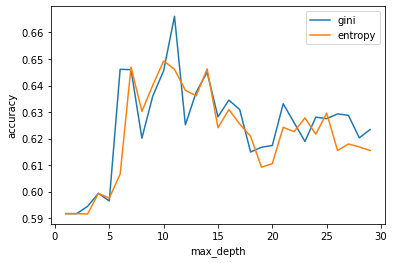

In [8]:
#find  optimal parameters: GINI OR ENTROPY 
max_depth = []
acc_gini = []
acc_entropy = []
for i in range(1,30):
    dtree = DecisionTreeClassifier(criterion="gini", max_depth=i, class_weight= {0: 1.43631197 , 1:0.76700502})
    dtree.fit(X_train, y_train)
    pred = dtree.predict(X_test)
    acc_gini.append(accuracy_score(y_test, pred))
 ####
    dtree = DecisionTreeClassifier(criterion="entropy", max_depth=i, class_weight= {0: 1.43631197 , 1:0.76700502})
    dtree.fit(X_train, y_train)
    pred = dtree.predict(X_test)
    acc_entropy.append(accuracy_score(y_test, pred))
 ####
    max_depth.append(i)
d = pd.DataFrame({"acc_gini":pd.Series(acc_gini), 
 "acc_entropy":pd.Series(acc_entropy),
 "max_depth":pd.Series(max_depth)})


# visualizing changes in parameters
plt.plot("max_depth","acc_gini", data=d, label="gini")
plt.plot("max_depth","acc_entropy", data=d, label="entropy")
plt.xlabel("max_depth")
plt.ylabel("accuracy")
plt.legend()

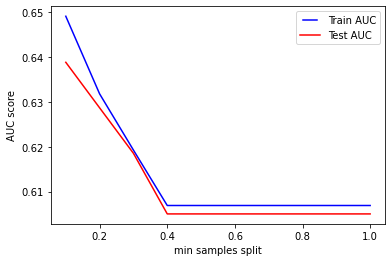

In [9]:
#find min samples split
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
train_results = []
test_results = []
for min_samples_split in min_samples_splits:
    dt = DecisionTreeClassifier(min_samples_split=min_samples_split, class_weight= {0: 1.43631197 , 1:0.76700502})
    dt.fit(X_train, y_train)
    train_pred = dt.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds =    roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = dt.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_splits, train_results, "b", label="Train AUC")
line2, = plt.plot(min_samples_splits, test_results, "r", label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("min samples split")
plt.show()

#### Grid Search 
Grid search is a tuning technique that attempts to compute the optimum values of hyperparameters.

In [34]:
dt = DecisionTreeClassifier(class_weight= {0: 1.43631197 , 1:0.76700502})

dt_classifier = RandomizedSearchCV(dt,param_dict, 
                   cv= 3,
                   n_jobs= -1, random_state = seed)

dt_classifier.fit(X_train, y_train)

C:\Users\giusp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:921: UserWarning: One or more of the test scores are non-finite: [0.59506117 0.58169043 0.58169043        nan 0.59506117 0.60236064
 0.59506117 0.60249443 0.61061373        nan]
  category=UserWarning


RandomizedSearchCV(cv=3,
                   estimator=DecisionTreeClassifier(class_weight={0: 1.43631197,
                                                                  1: 0.76700502}),
                   n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': range(1, 10),
                                        'min_samples_leaf': range(1, 5),
                                        'min_samples_split': range(0, 10)},
                   random_state=50)

In [35]:
print(dt_classifier.best_params_)
print(dt_classifier.best_estimator_)

{'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 7, 'criterion': 'entropy'}
DecisionTreeClassifier(class_weight={0: 1.43631197, 1: 0.76700502},
                       criterion='entropy', max_depth=7, min_samples_leaf=2,
                       min_samples_split=3)


In [36]:
print(classification_report(y_test, dt_classifier.best_estimator_.predict(X_test)))

              precision    recall  f1-score   support

           0       0.49      0.61      0.54      2548
           1       0.76      0.67      0.71      4771

    accuracy                           0.65      7319
   macro avg       0.63      0.64      0.63      7319
weighted avg       0.67      0.65      0.65      7319



#### Pruning decision tree

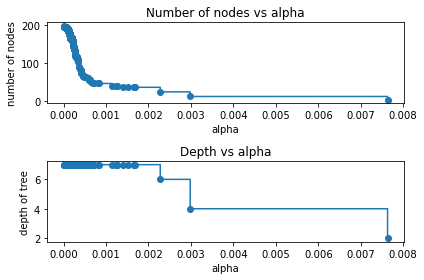

In [37]:

path=DecisionTreeClassifier(random_state=1).\
cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities



clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(criterion = 'entropy' , random_state=seed,ccp_alpha=ccp_alpha, class_weight= {0: 1.43631197 , 1:0.76700502},  max_depth=7, min_samples_split = 3, min_samples_leaf = 3)
    clf.fit(X_train, y_train)
    clfs.append(clf)
    
    
    

clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]


node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

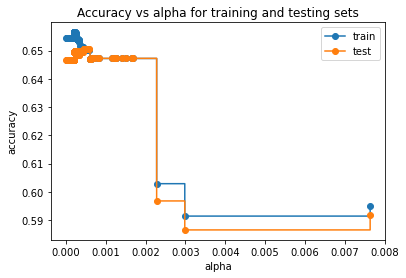

In [38]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]
fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()


In [39]:
index_best_model = np.argmax(test_scores)
best_model = clfs[index_best_model]
print('Training accuracy of best model: ',best_model.score(X_train, y_train))
print('Test accuracy of best model: ',best_model.score(X_test, y_test))

Training accuracy of best model:  0.6503172112695272
Test accuracy of best model:  0.6503620713212187


In [40]:
best_model

DecisionTreeClassifier(ccp_alpha=0.0004506179058949983,
                       class_weight={0: 1.43631197, 1: 0.76700502},
                       criterion='entropy', max_depth=7, min_samples_leaf=3,
                       min_samples_split=3, random_state=50)

### Best model 

I put the optimal parameters in the best model and I create the graph.

In [43]:
#fit model with best parameters 

clf_pruned = DecisionTreeClassifier(criterion = 'entropy' ,ccp_alpha=0.0004506179058949983, random_state=seed, class_weight= {0: 1.43631197 , 1:0.76700502},  max_depth=7, min_samples_split = 3, min_samples_leaf = 3)
clf_pruned.fit(X_train, y_train)
pred = clf_pruned.predict(X_test)
accuracy_score(y_test, pred)
#Accuracy: 0.66


xvar = df_get_dummies.drop('qb5', axis=1)
feature_cols = xvar.columns
dot_data = StringIO()
export_graphviz(clf_pruned, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = feature_cols,class_names=['No Action','Yes Action'])
from pydot import graph_from_dot_data
(graph, ) = graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())
graph.write_png('action-prune.png') 



In [44]:
print(classification_report(y_test, clf_pruned.predict(X_test)))

              precision    recall  f1-score   support

           0       0.50      0.60      0.55      2548
           1       0.76      0.68      0.72      4771

    accuracy                           0.65      7319
   macro avg       0.63      0.64      0.63      7319
weighted avg       0.67      0.65      0.66      7319



#### Confusion Matrix

Text(0.5, 15.0, 'Predicted label')

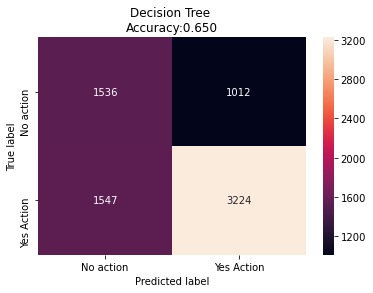

In [45]:
#y_pred = dt.predict(X_test)
ac = accuracy_score(y_test,clf_pruned.predict(X_test))
#print('Accuracy is: ',ac)

#plt.figure(figsize=(5.5,4))

cm_df = confusion_matrix(y_test,clf_pruned.predict(X_test))
cm_df = pd.DataFrame(cm_df,
                     index = ['No action','Yes Action'], 
                     columns = ['No action','Yes Action'])
sns.heatmap(cm_df,annot=True,fmt="d")
plt.title('Decision Tree \nAccuracy:{0:.3f}'.format(accuracy_score(y_test, clf_pruned.predict(X_test))))
plt.ylabel('True label')
plt.xlabel('Predicted label')
#plt.savefig('rf_confusionmatrix-df24.png')


#### Feature importance


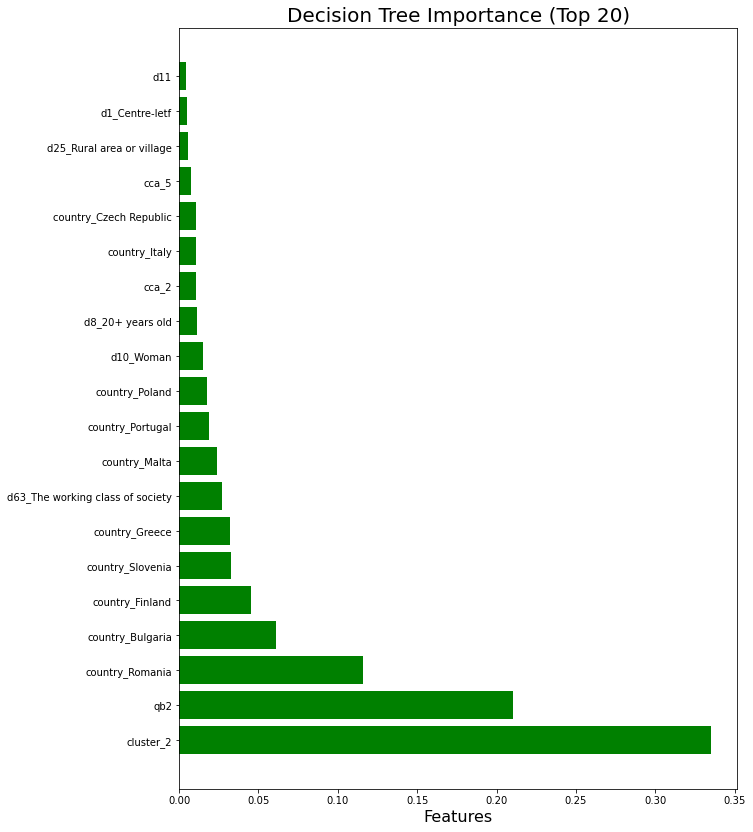

In [46]:
feature_importances = list(zip(X_train, clf_pruned.feature_importances_))
# Then sort the feature importances by most important first
feature_importances_ranked = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances
#[print('Feature: {:35} Importance: {}'.format(*pair)) for pair in feature_importances_ranked];
# Plot the top 25 feature importance
feature_names_20 = [i[0] for i in feature_importances_ranked[:20]]
y_ticks = np.arange(0, len(feature_names_20))
x_axis = [i[1] for i in feature_importances_ranked[:20]]
plt.figure(figsize = (10, 14))
plt.barh(feature_names_20, x_axis, color = 'g')   #horizontal barplot
plt.title('Decision Tree Importance (Top 20)',
          fontdict= {'fontsize' : 20})
plt.xlabel('Features',fontdict= {'fontsize' : 16})
plt.show()


roc_auc_score for Decision Tree:  0.6830476317705709


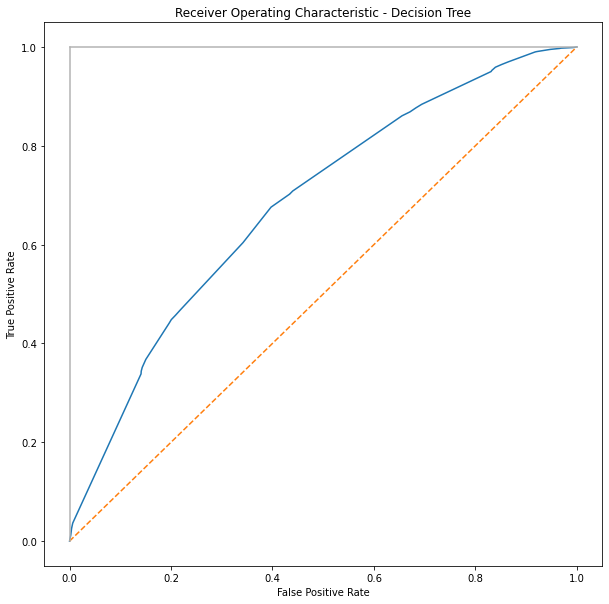

In [47]:
y_score2 = clf_pruned.predict_proba(X_test)[:,1]
false_positive_rate2, true_positive_rate2, threshold2 = roc_curve(y_test, y_score2)
print('roc_auc_score for Decision Tree: ', roc_auc_score(y_test, y_score2))
plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - Decision Tree')
plt.plot(false_positive_rate2, true_positive_rate2)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### High Risk Perception


In this part there is data of individuals who have a high Climate Change Risk Perception (q2 >= 6).
I will predict pro-environmental behaviour (qb5). The predictors are: clusters and correlational class analysis of other questions about climate change, socio-demograpich variables. 



I repeate the same codes

In [48]:


cc_num = df1[['qb5', 'd1', 'd10','d11', 'country','d8','d25', 'd63','d7','cluster', 'cca']]

cat_var =['d1','d10', 'country','d8','d25', 'd63','d7','cluster', 'cca']
df_get_dummies = pd.get_dummies(  cc_num , columns = cat_var)



X = df_get_dummies.drop('qb5',axis=1)
y = df_get_dummies.loc[:, df_get_dummies.columns == 'qb5']

seed = 99  # so that the result is reproducible
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.333, random_state = seed,stratify=y)

class_weights = compute_class_weight('balanced', classes = np.unique(y_train), y = np.ravel(y_train))
class_weights
                           





array([1.56739773, 0.73421448])

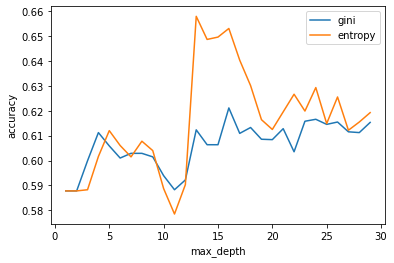

In [49]:
max_depth = []
acc_gini = []
acc_entropy = []
for i in range(1,30):
    dtree = DecisionTreeClassifier(criterion="gini", random_state = seed,max_depth=i, class_weight= {0: 1.56739773 , 1:0.73421448} )
    dtree.fit(X_train, y_train)
    pred = dtree.predict(X_test)
    acc_gini.append(accuracy_score(y_test, pred))
 ####
    dtree = DecisionTreeClassifier(criterion="entropy",random_state = seed, max_depth=i,  class_weight= {0: 1.56739773 , 1:0.73421448} )
    dtree.fit(X_train, y_train)
    pred = dtree.predict(X_test)
    acc_entropy.append(accuracy_score(y_test, pred))
 ####
    max_depth.append(i)
d = pd.DataFrame({"acc_gini":pd.Series(acc_gini), 
 "acc_entropy":pd.Series(acc_entropy),
 "max_depth":pd.Series(max_depth)})


# visualizing changes in parameters
plt.plot("max_depth","acc_gini", data=d, label="gini")
plt.plot("max_depth","acc_entropy", data=d, label="entropy")
plt.xlabel("max_depth")
plt.ylabel("accuracy")
plt.legend()

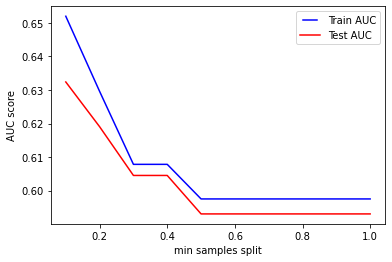

In [50]:
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
train_results = []
test_results = []
for min_samples_split in min_samples_splits:
    dt = DecisionTreeClassifier(min_samples_split=min_samples_split,random_state = seed, class_weight= {0: 1.56739773 , 1:0.73421448} )
    dt.fit(X_train, y_train)
    train_pred = dt.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds =    roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = dt.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_splits, train_results, "b", label="Train AUC")
line2, = plt.plot(min_samples_splits, test_results, "r", label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("min samples split")
plt.show()

In [51]:
dt = DecisionTreeClassifier(class_weight= {0: 1.56739773 , 1:0.73421448})
dt_classifier = RandomizedSearchCV(dt,param_dict, 
                   cv= 3,
                   n_jobs= -1,random_state = seed)

dt_classifier.fit(X_train, y_train)

C:\Users\giusp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:921: UserWarning: One or more of the test scores are non-finite: [       nan 0.59704435 0.61221523 0.60435565 0.61260937 0.61535875
 0.60349091 0.61260937 0.60639968 0.61245217]
  category=UserWarning


RandomizedSearchCV(cv=3,
                   estimator=DecisionTreeClassifier(class_weight={0: 1.56739773,
                                                                  1: 0.73421448}),
                   n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': range(1, 10),
                                        'min_samples_leaf': range(1, 5),
                                        'min_samples_split': range(0, 10)},
                   random_state=99)

In [52]:
print(dt_classifier.best_params_)
print(dt_classifier.best_estimator_)

{'min_samples_split': 7, 'min_samples_leaf': 1, 'max_depth': 7, 'criterion': 'entropy'}
DecisionTreeClassifier(class_weight={0: 1.56739773, 1: 0.73421448},
                       criterion='entropy', max_depth=7, min_samples_split=7)


#### Pruning Decision Tree

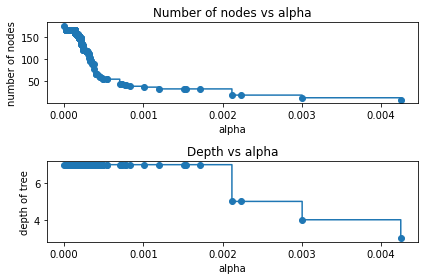

In [53]:
path=DecisionTreeClassifier(random_state=1).\
cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities



clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(criterion = 'entropy' , random_state=seed,ccp_alpha=ccp_alpha, class_weight= {0: 1.56739773 , 1:0.73421448},  max_depth=7, min_samples_split = 7, min_samples_leaf = 1)
    clf.fit(X_train, y_train)
    clfs.append(clf)
    
    
    

clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]


node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

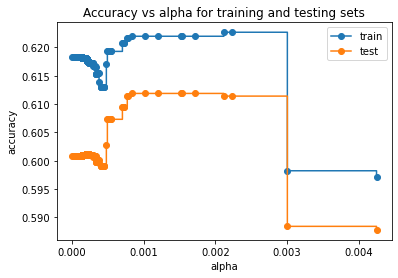

In [54]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]
fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

In [55]:
index_best_model = np.argmax(test_scores)
best_model = clfs[index_best_model]
print('Training accuracy of best model: ',best_model.score(X_train, y_train))
print('Test accuracy of best model: ',best_model.score(X_test, y_test))

best_model

Training accuracy of best model:  0.6219636821004638
Test accuracy of best model:  0.6118721461187214


DecisionTreeClassifier(ccp_alpha=0.0008361263263303581,
                       class_weight={0: 1.56739773, 1: 0.73421448},
                       criterion='entropy', max_depth=7, min_samples_split=7,
                       random_state=99)

#### Best Model

In [56]:
#fit model with best parameters 

clf_pruned = DecisionTreeClassifier(criterion = 'entropy' , random_state=seed,ccp_alpha=0.0008361263263303581, class_weight= {0: 1.56739773 , 1:0.73421448},  max_depth=7, min_samples_split = 7, min_samples_leaf = 1)
clf_pruned.fit(X_train, y_train)
pred = clf_pruned.predict(X_test)
accuracy_score(y_test, pred)
#Accuracy: 0.66


xvar = df_get_dummies.drop('qb5', axis=1)
feature_cols = xvar.columns
dot_data = StringIO()
export_graphviz(clf_pruned, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = feature_cols,class_names=['No Action','Yes Action'])
from pydot import graph_from_dot_data
(graph, ) = graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())
graph.write_png('action-prune2.png') 



In [57]:
print(classification_report(y_test, clf_pruned.predict(X_test)))

              precision    recall  f1-score   support

           0       0.43      0.63      0.51      2026
           1       0.78      0.60      0.68      4325

    accuracy                           0.61      6351
   macro avg       0.60      0.62      0.59      6351
weighted avg       0.67      0.61      0.62      6351



In [58]:
xvar = df_get_dummies.drop('qb5', axis=1)
feature_cols = xvar.columns
dot_data = StringIO()
export_graphviz(clf_pruned, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = feature_cols,class_names=['No Action','Yes Action'])
from pydot import graph_from_dot_data
(graph, ) = graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())
graph.write_png('action-prune2.png') 



Text(0.5, 15.0, 'Predicted label')

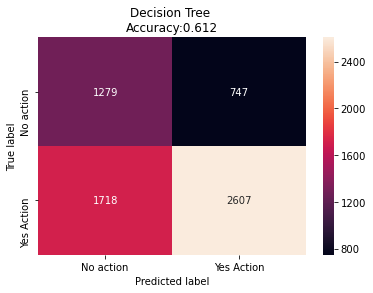

In [59]:
#y_pred = dt.predict(X_test)
ac = accuracy_score(y_test,clf_pruned.predict(X_test))
#print('Accuracy is: ',ac)



#plt.figure(figsize=(5.5,4))

cm_df = confusion_matrix(y_test,clf_pruned.predict(X_test))
cm_df = pd.DataFrame(cm_df,
                     index = ['No action','Yes Action'], 
                     columns = ['No action','Yes Action'])
sns.heatmap(cm_df,annot=True,fmt="d")
plt.title('Decision Tree \nAccuracy:{0:.3f}'.format(accuracy_score(y_test, clf_pruned.predict(X_test))))
plt.ylabel('True label')
plt.xlabel('Predicted label')
#plt.savefig('rf_confusionmatrix-df24.png')


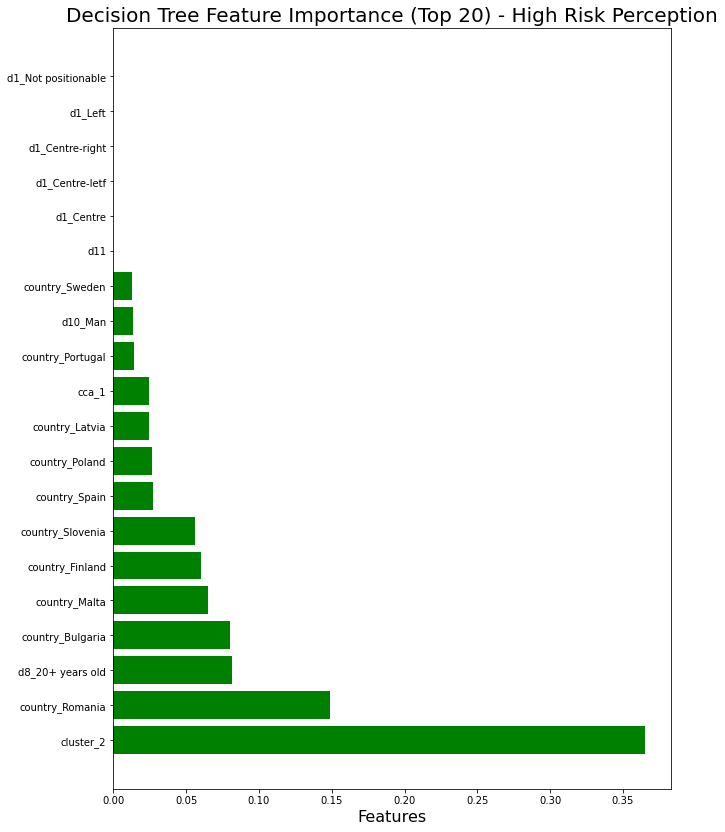

In [60]:
feature_importances = list(zip(X_train, clf_pruned.feature_importances_))
# Then sort the feature importances by most important first
feature_importances_ranked = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances
#[print('Feature: {:35} Importance: {}'.format(*pair)) for pair in feature_importances_ranked];
# Plot the top 25 feature importance
feature_names_20 = [i[0] for i in feature_importances_ranked[:20]]
y_ticks = np.arange(0, len(feature_names_20))
x_axis = [i[1] for i in feature_importances_ranked[:20]]
plt.figure(figsize = (10, 14))
plt.barh(feature_names_20, x_axis, color = 'g')   #horizontal barplot
plt.title('Decision Tree Feature Importance (Top 20) - High Risk Perception',
          fontdict= {'fontsize' : 20})
plt.xlabel('Features',fontdict= {'fontsize' : 16})
plt.show()


roc_auc_score for Random Forest - High Risk Perception:  0.6507063093084696


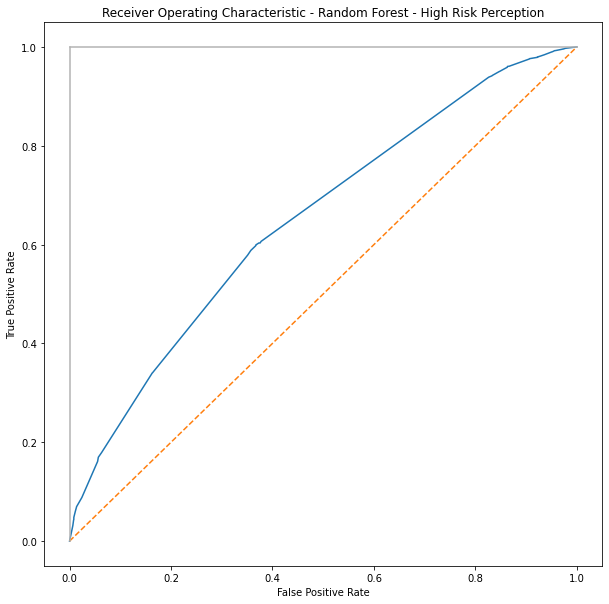

In [61]:
y_score2 = dt_classifier.best_estimator_.predict_proba(X_test)[:,1]
false_positive_rate2, true_positive_rate2, threshold2 = roc_curve(y_test, y_score2)
print('roc_auc_score for Random Forest - High Risk Perception: ', roc_auc_score(y_test, y_score2))
plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - Random Forest - High Risk Perception')
plt.plot(false_positive_rate2, true_positive_rate2)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Low Risk Perception

In this part there is data of individuals who have a low Climate Change Risk Perception (q2 <= 5).
I will predict pro-environmental behaviour (qb5). The predictors are: clusters and correlational class analysis of other questions about climate change, socio-demograpich variables. 



I repeate the same codes


In [62]:
cc_num = df2[['qb5', 'd1', 'd10','d11', 'country','d8','d25', 'd63','d7','cluster', 'cca']]

cat_var =['d1','d10', 'country','d8','d25', 'd63','d7','cluster', 'cca']
df_get_dummies = pd.get_dummies(  cc_num , columns = cat_var)



X = df_get_dummies.drop('qb5',axis=1)
y = df_get_dummies.loc[:, df_get_dummies.columns == 'qb5']

seed = 50  # so that the result is reproducible
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.333, random_state = seed,stratify=y)

class_weights = compute_class_weight('balanced', classes = np.unique(y_train), y = np.ravel(y_train))
class_weights
                    
    
    
    

array([0.92727273, 1.08510638])

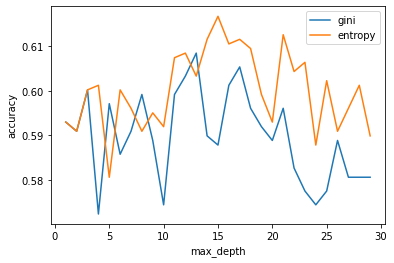

In [63]:
max_depth = []
acc_gini = []
acc_entropy = []
for i in range(1,30):
    dtree = DecisionTreeClassifier(criterion="gini", random_state = seed,max_depth=i, class_weight= {0: 0.92727273 , 1:1.08510638} )
    dtree.fit(X_train, y_train)
    pred = dtree.predict(X_test)
    acc_gini.append(accuracy_score(y_test, pred))
 ####
    dtree = DecisionTreeClassifier(criterion="entropy",random_state = seed, max_depth=i,  class_weight= {0: 0.92727273 , 1:1.08510638})
    dtree.fit(X_train, y_train)
    pred = dtree.predict(X_test)
    acc_entropy.append(accuracy_score(y_test, pred))
 ####
    max_depth.append(i)
d = pd.DataFrame({"acc_gini":pd.Series(acc_gini), 
 "acc_entropy":pd.Series(acc_entropy),
 "max_depth":pd.Series(max_depth)})


# visualizing changes in parameters
plt.plot("max_depth","acc_gini", data=d, label="gini")
plt.plot("max_depth","acc_entropy", data=d, label="entropy")
plt.xlabel("max_depth")
plt.ylabel("accuracy")
plt.legend()

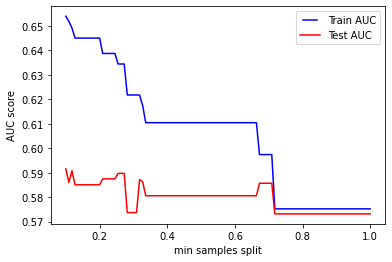

In [64]:

min_samples_splits = np.linspace(0.1, 1.0, 100, endpoint=True)
train_results = []
test_results = []
for min_samples_split in min_samples_splits:
    dt = DecisionTreeClassifier(min_samples_split=min_samples_split,random_state = seed, class_weight= {0: 0.92727273 , 1:1.08510638})
    dt.fit(X_train, y_train)
    train_pred = dt.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds =    roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = dt.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_splits, train_results, "b", label="Train AUC")
line2, = plt.plot(min_samples_splits, test_results, "r", label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("min samples split")
plt.show()

In [65]:
dt = DecisionTreeClassifier(class_weight={0: 0.92727273 , 1:1.08510638})
dt_classifier = RandomizedSearchCV(dt,param_dict, 
                   cv= 3,
                   n_jobs= -1, random_state = seed)

dt_classifier.fit(X_train, y_train)

C:\Users\giusp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:921: UserWarning: One or more of the test scores are non-finite: [0.59442724 0.6006192  0.6006192         nan 0.59442724 0.63106295
 0.59442724 0.61042312 0.61816305        nan]
  category=UserWarning


RandomizedSearchCV(cv=3,
                   estimator=DecisionTreeClassifier(class_weight={0: 0.92727273,
                                                                  1: 1.08510638}),
                   n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': range(1, 10),
                                        'min_samples_leaf': range(1, 5),
                                        'min_samples_split': range(0, 10)},
                   random_state=50)

In [66]:
print(dt_classifier.best_params_)
print(dt_classifier.best_estimator_)

{'min_samples_split': 6, 'min_samples_leaf': 1, 'max_depth': 6, 'criterion': 'gini'}
DecisionTreeClassifier(class_weight={0: 0.92727273, 1: 1.08510638}, max_depth=6,
                       min_samples_split=6)


#### Pruning

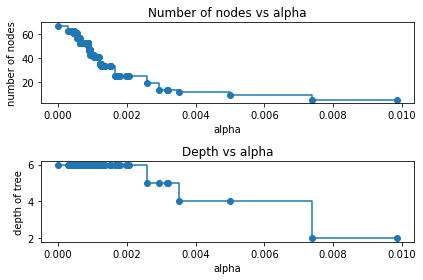

In [67]:
path=DecisionTreeClassifier(random_state=1).\
cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities



clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(criterion = 'gini' , random_state=seed,ccp_alpha=ccp_alpha, class_weight= {0: 0.92727273, 1: 1.08510638},  max_depth=6, min_samples_split =6, min_samples_leaf = 1)
    clf.fit(X_train, y_train)
    clfs.append(clf)
    
    
    

clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]


node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

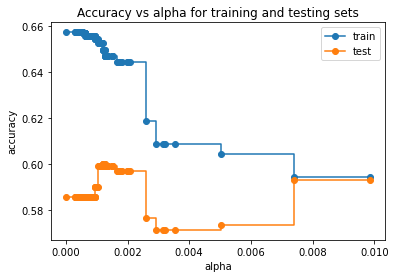

In [68]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]
fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

In [69]:
index_best_model = np.argmax(test_scores)
best_model = clfs[index_best_model]
print('Training accuracy of best model: ',best_model.score(X_train, y_train))
print('Test accuracy of best model: ',best_model.score(X_test, y_test))

best_model

Training accuracy of best model:  0.6496388028895769
Test accuracy of best model:  0.6002066115702479


DecisionTreeClassifier(ccp_alpha=0.0012125042043045226,
                       class_weight={0: 0.92727273, 1: 1.08510638}, max_depth=6,
                       min_samples_split=6, random_state=50)

#### Best Model

In [70]:
#fit model with best parameters 

clf_pruned = DecisionTreeClassifier(criterion = 'gini' , random_state=seed,ccp_alpha=0.0012125042043045226, class_weight= {0: 0.92727273, 1: 1.08510638},  max_depth=6, min_samples_split =6, min_samples_leaf = 1)
clf_pruned.fit(X_train, y_train)
pred = clf_pruned.predict(X_test)
accuracy_score(y_test, pred)
#Accuracy: 0.66


xvar = df_get_dummies.drop('qb5', axis=1)
feature_cols = xvar.columns
dot_data = StringIO()
export_graphviz(clf_pruned, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = feature_cols,class_names=['No Action','Yes Action'])
from pydot import graph_from_dot_data
(graph, ) = graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())
graph.write_png('action-prune3.png') 


In [71]:
print(classification_report(y_test, clf_pruned.predict(X_test)))

              precision    recall  f1-score   support

           0       0.63      0.62      0.63       522
           1       0.56      0.58      0.57       446

    accuracy                           0.60       968
   macro avg       0.60      0.60      0.60       968
weighted avg       0.60      0.60      0.60       968



Text(0.5, 15.0, 'Predicted label')

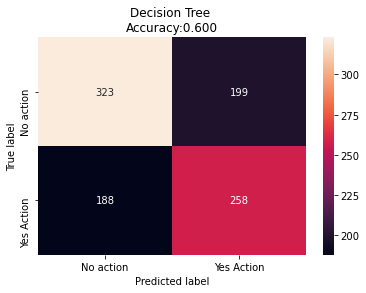

In [72]:
#y_pred = dt.predict(X_test)
ac = accuracy_score(y_test,clf_pruned.predict(X_test))
#print('Accuracy is: ',ac)



#plt.figure(figsize=(5.5,4))

cm_df = confusion_matrix(y_test,clf_pruned.predict(X_test))
cm_df = pd.DataFrame(cm_df,
                     index = ['No action','Yes Action'], 
                     columns = ['No action','Yes Action'])
sns.heatmap(cm_df,annot=True,fmt="d")
plt.title('Decision Tree \nAccuracy:{0:.3f}'.format(accuracy_score(y_test, clf_pruned.predict(X_test))))
plt.ylabel('True label')
plt.xlabel('Predicted label')
#plt.savefig('rf_confusionmatrix-df24.png')


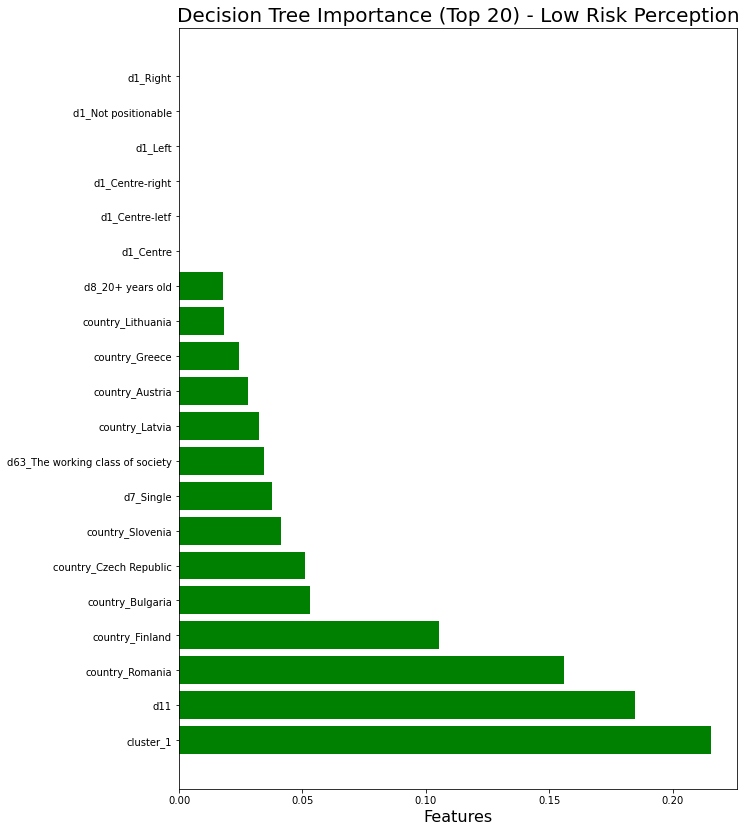

In [73]:
feature_importances = list(zip(X_train, clf_pruned.feature_importances_))
# Then sort the feature importances by most important first
feature_importances_ranked = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances
#[print('Feature: {:35} Importance: {}'.format(*pair)) for pair in feature_importances_ranked];
# Plot the top 25 feature importance
feature_names_20 = [i[0] for i in feature_importances_ranked[:20]]
y_ticks = np.arange(0, len(feature_names_20))
x_axis = [i[1] for i in feature_importances_ranked[:20]]
plt.figure(figsize = (10, 14))
plt.barh(feature_names_20, x_axis, color = 'g')   #horizontal barplot
plt.title('Decision Tree Importance (Top 20) - Low Risk Perception',
          fontdict= {'fontsize' : 20})
plt.xlabel('Features',fontdict= {'fontsize' : 16})
plt.show()

roc_auc_score for Random Forest - High Risk Perception:  0.620913011356803


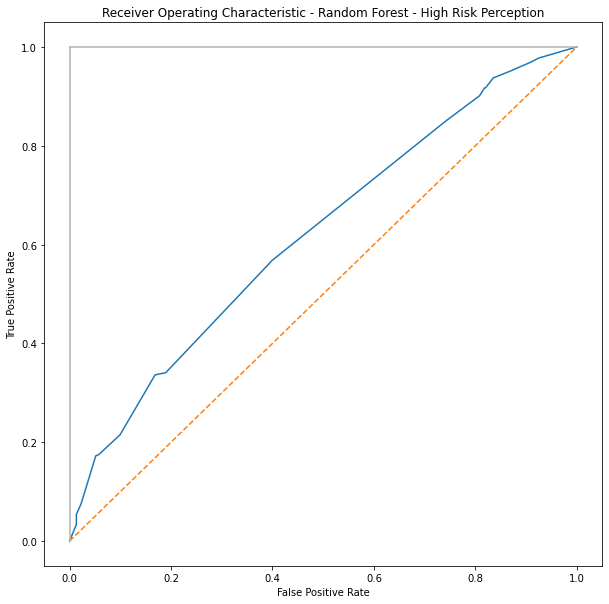

In [74]:
y_score2 = dt_classifier.best_estimator_.predict_proba(X_test)[:,1]
false_positive_rate2, true_positive_rate2, threshold2 = roc_curve(y_test, y_score2)
print('roc_auc_score for Random Forest - High Risk Perception: ', roc_auc_score(y_test, y_score2))
plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - Random Forest - High Risk Perception')
plt.plot(false_positive_rate2, true_positive_rate2)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### REFERENCES

https://towardsdatascience.com/decision-tree-in-python-b433ae57fb93

https://towardsdatascience.com/understanding-decision-tree-classification-with-scikit-learn-2ddf272731bd

https://towardsdatascience.com/decision-tree-build-prune-and-visualize-it-using-python-12ceee9af752

https://towardsdatascience.com/decision-tree-classifier-and-cost-computation-pruning-using-python-b93a0985ea77

https://medium.com/@mohtedibf/indepth-parameter-tuning-for-decision-tree-6753118a03c3

https://medium.com/ai-in-plain-english/hyperparameter-tuning-of-decision-tree-classifier-using-gridsearchcv-2a6ebcaffeda

https://medium.com/swlh/post-pruning-decision-trees-using-python-b5d4bcda8e23